# Cluster Analysis for Business - Course paper

## 1) Clustering and Representation Learning

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.datasets import mnist
import random
import time
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import seaborn as sns
from numpy import linalg as LA

In [2]:
path ='https://raw.githubusercontent.com/milaan9/Clustering-Datasets/refs/heads/master/02.%20Synthetic/banana.csv'
data = pd.read_csv(path)
data.head()

,x,y,class
0,0.228,0.559,1
1,0.216,0.528,1
2,0.221,0.552,1
3,0.215,0.538,1
4,0.224,0.548,1


### a) Visualize the data in a 2-dimensional scatter plot

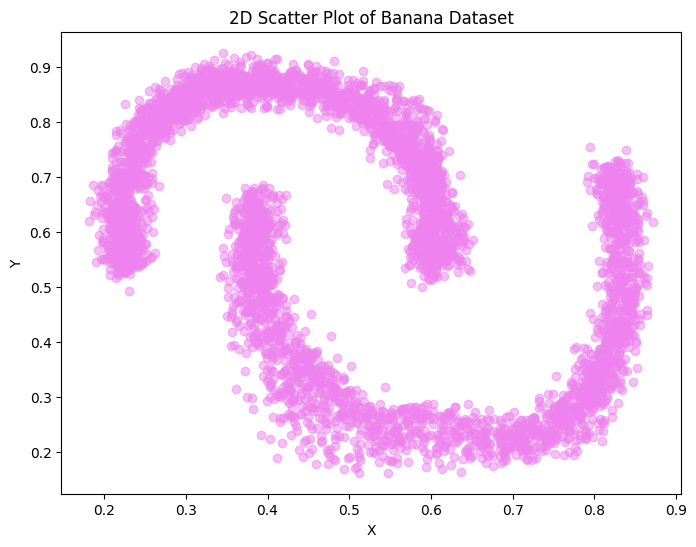

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(data['x'], data['y'], c='violet', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Scatter Plot of Banana Dataset')
plt.show()

### b) Based on your intuition, explain what the number of clusters in the data should be
The data seems to form two distinct, curved clusters resembling a banana shape. Therefore, intuitively, the number of clusters appears to be 2.
This is because there are two separate regions where the data points group together, and the space between these regions is relatively empty.

### c) Use the Euclidean distance and the ward and average linkage methods and plot the dendrogram for both linkage methods. Discuss the number of clusters that the dendrograms suggest and contrast the result with your answer in b)

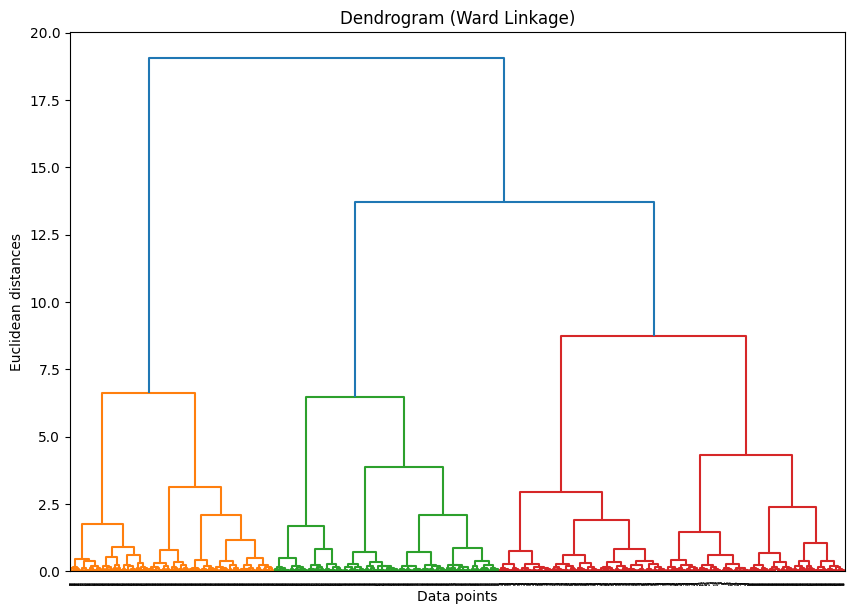

In [4]:
x = data[['x', 'y']].values
cl_ward = linkage(x, method='ward', metric='euclidean')
plt.figure(figsize=(10, 7))
plt.title('Dendrogram (Ward Linkage)')
dendrogram(cl_ward, leaf_font_size=0)
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()

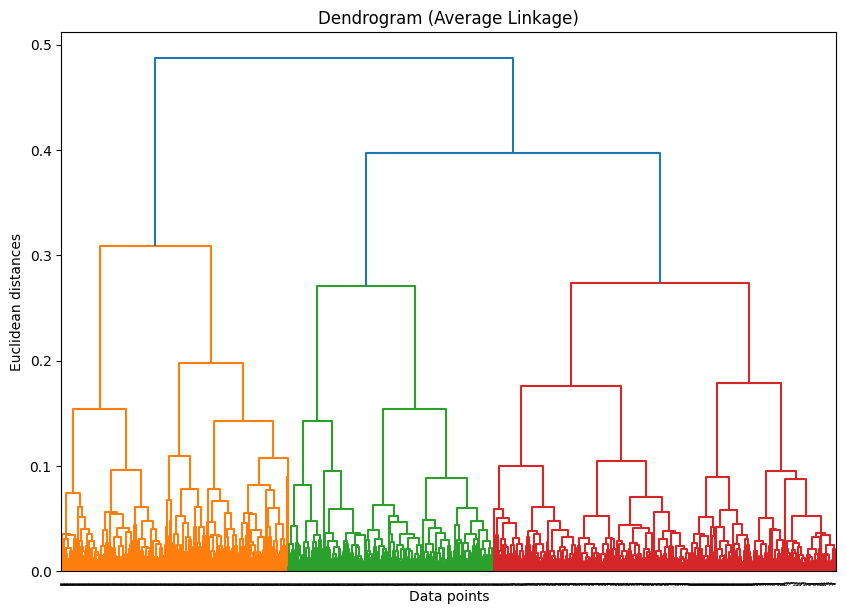

In [5]:
cl_average = linkage(x, method='average', metric='euclidean')
plt.figure(figsize=(10, 7))
plt.title('Dendrogram (Average Linkage)')
dendrogram(cl_average, leaf_font_size=0)
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()

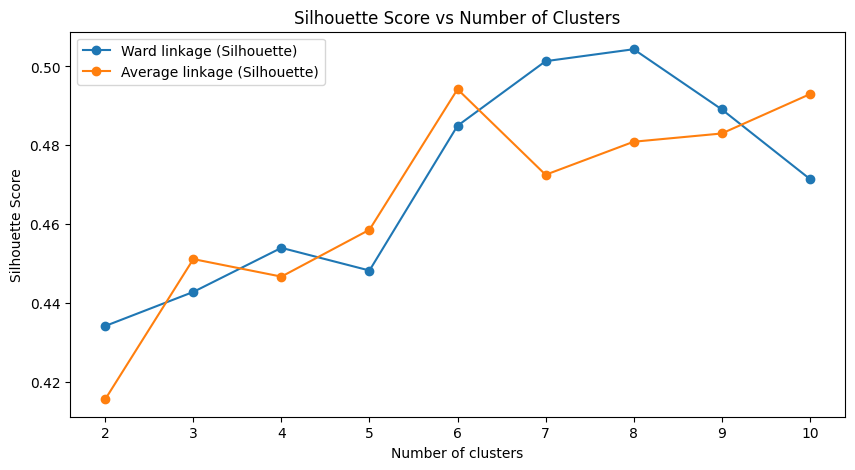

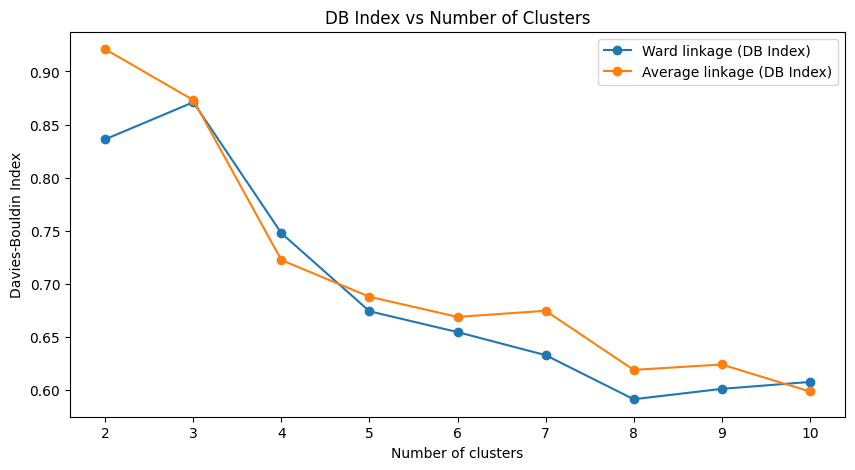

In [6]:
k_range = range(2, 11) # evaluate the number of clusters from 2 to 10

silhouette_ward_scores = []
db_ward_scores = []
silhouette_average_scores = []
db_average_scores = []

for k in k_range:
    labels_ward = fcluster(cl_ward, k, criterion='maxclust')
    silhouette_ward_scores.append(silhouette_score(x, labels_ward))
    db_ward_scores.append(davies_bouldin_score(x, labels_ward))

    labels_average = fcluster(cl_average, k, criterion='maxclust')
    silhouette_average_scores.append(silhouette_score(x, labels_average))
    db_average_scores.append(davies_bouldin_score(x, labels_average))

plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_ward_scores, label='Ward linkage (Silhouette)', marker='o')
plt.plot(k_range, silhouette_average_scores, label='Average linkage (Silhouette)', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_range, db_ward_scores, label='Ward linkage (DB Index)', marker='o')
plt.plot(k_range, db_average_scores, label='Average linkage (DB Index)', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('DB Index vs Number of Clusters')
plt.legend()
plt.show()

Based on the evaluation of the Davies-Bouldin (DB) index and the Silhouette score, the optimal number of clusters for this dataset appears to be 8 clusters. The DB index, is at one of its lowest points at 8 clusters, indicating good separation between clusters. Simultaneously, the Silhouette score reaches its peak at 8 clusters for Ward linkage. This combination of a low DB index and a high Silhouette score suggests that 8 clusters is the most suitable choice.

### d) Select the K parameter based on your answer in exercise b), run the K-means algorithm, and visualize a 2-dimensional scatter plot where the K-means cluster labels are used as colors in the scatters. Comment on the results.

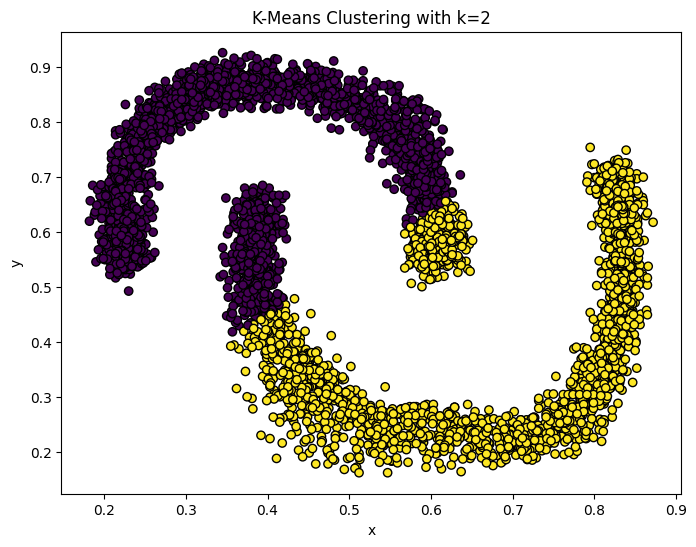

In [7]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(x)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('K-Means Clustering with k=2')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The K-means clustering with  K=2  separates the data into two groups, but the clusters in the data are curved, and K-means is better at finding linear clusters. Because of this, it doesn’t capture the real shape of the clusters very well, especially where they are close to each other.

### autoencoder definition

In [8]:
# Autoencoder definition
labels = data['class'].copy().to_numpy()
y = tf.keras.utils.to_categorical(labels-1,num_classes=2)
class AutoEncoder(tf.keras.Model):
    def __init__(self, enc, dec, name='autoencoder'):
      super().__init__()
      self.encoder = enc
      self.decoder = dec
      self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

      self.params = encoder.trainable_variables + decoder.trainable_variables

    def call(self, inputs):
      x,y = inputs
      z = self.encoder(x)
      x_hat = self.decoder(z)

      self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, x_hat))

    @tf.function
    def train(self, x, optimizer):
        with tf.GradientTape() as tape:
            enc_dec = self.call(x)
        gradients = tape.gradient(self.loss, self.params)
        optimizer.apply_gradients(zip(gradients, self.params))

        return self.loss

    def rep_learning(self, x):
      z = self.encoder(x)

      return z

    def reconstruct(self, x):
      z = self.rep_learning(x)
      x_hat = self.decoder(z)

      return x_hat

In [9]:
# plot functions
def plot_digits(x_test,decoded_imgs,n):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

def nice_scatter(z_tsne, y_sample, title):
    print('plotting nice scatter...')
    COLORS=[[1.0000, 0,      0     ],
            [0,      1.0000, 0     ],
            [0,      0,      1.0000],
            [1.0000, 0,      1.0000],
            [0.9569, 0.6431, 0.3765],
            [0.4000, 0.8039, 0.6667],
            [0.5529, 0.7137, 0.8039],
            [0.8039, 0.5882, 0.8039],
            [0.7412, 0.7176, 0.4196],
            [0,      0,      0     ]]

    fig, ax = plt.subplots()
    for i, ((x,y),) in enumerate(zip(z_tsne)):
        #rot = random.randint(0,0) # in case you want randomly rotated numbers
        rot = 0
        ax.text(x, y, y_sample[i], color=COLORS[y_sample[i]-1], ha="center", va="center", rotation = rot, fontsize=5)
        ax.plot(x,y, alpha=0.0)
        ax.axis('off')
        plt.title(title)

In [10]:
print(x.shape)

(4811, 2)


In [11]:
# hyperparameters
input_shape = (2, )
activation = 'tanh'
units = 10
z_dim = 2

In [12]:
# encoder and decoder architecture

encoder = Sequential([
    layers.InputLayer(input_shape=(input_shape)),
    layers.Dense(units, activation=activation),  # 1st hidden layer
    layers.Dense(units, activation=activation),  # 2nd hidden layer
    layers.Dense(units, activation=activation),  # 3rd hidden layer
    layers.Dense(z_dim, activation='linear'),    # output layer (latent space) with linear activation
])

decoder = Sequential([
    layers.InputLayer(input_shape=(z_dim,)),
    layers.Dense(units, activation=activation),  # 1st hidden layer
    layers.Dense(units, activation=activation),  # 2nd hidden layer
    layers.Dense(units, activation=activation),  # 3rd hidden layer
    layers.Dense(2, activation='linear'),  # output layer with linear activation
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [18]:
seed = 42 # You can choose any number
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

autoencoder = AutoEncoder(encoder, decoder)
batch_size = 256
tr_data = tf.data.Dataset.from_tensor_slices((x,y)).shuffle(x.shape[0]).batch(batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

counter = 0
epochs  = 1000
start = time.time()
losses = []
while counter < epochs:
  for i, x_batch in enumerate(tr_data):
    loss = autoencoder.train(x_batch, optimizer)
    losses.append(loss.numpy())  # storing loss
  counter+=1
  if counter%10==0:
    print('Model has been trained for {} epochs'.format(counter))
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print('Elapsed time: {}m {:.1f}s'.format(int(minutes), seconds))

Model has been trained for 10 epochs
Model has been trained for 20 epochs
Model has been trained for 30 epochs
Model has been trained for 40 epochs
Model has been trained for 50 epochs
Model has been trained for 60 epochs
Model has been trained for 70 epochs
Model has been trained for 80 epochs
Model has been trained for 90 epochs
Model has been trained for 100 epochs
Model has been trained for 110 epochs
Model has been trained for 120 epochs
Model has been trained for 130 epochs
Model has been trained for 140 epochs
Model has been trained for 150 epochs
Model has been trained for 160 epochs
Model has been trained for 170 epochs
Model has been trained for 180 epochs
Model has been trained for 190 epochs
Model has been trained for 200 epochs
Model has been trained for 210 epochs
Model has been trained for 220 epochs
Model has been trained for 230 epochs
Model has been trained for 240 epochs
Model has been trained for 250 epochs
Model has been trained for 260 epochs
Model has been traine

### e) Plot the loss across number of epochs and generate the latent representation for all data using the function rep_learning and visualize it in a 2-dimensional scatter plot

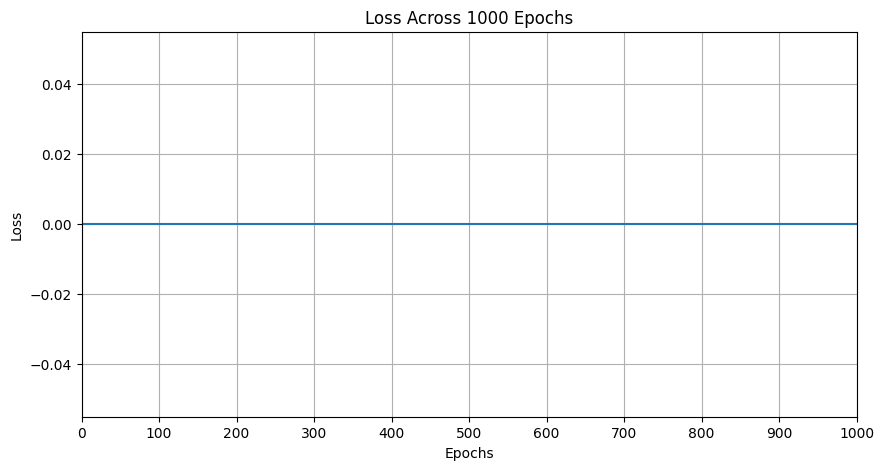

plotting nice scatter...


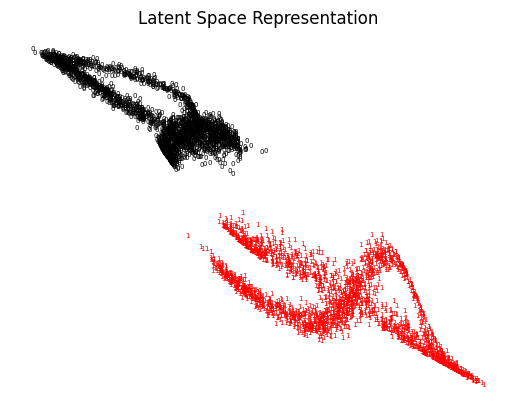

In [17]:
plt.figure(figsize=(10, 5))  
plt.plot(losses[:epochs])  
plt.xlim([0, epochs])  
plt.xticks(range(0, epochs + 1, 100))  
plt.title('Loss Across 1000 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  
plt.show()

z = autoencoder.rep_learning(x)
y_sample = np.argmax(y, axis=1)
nice_scatter(z, y_sample, title="Latent Space Representation")

In [27]:
### NON RUNNARE !!! (già salvato)
np.save('lentent_z.npy',z)

### f) Use K-means again, but this time you will cluster the latent representations that you obtained in exercise f). Visualize the latent representation and use the K-means cluster labels as colors in the scatters. Comment on the results.

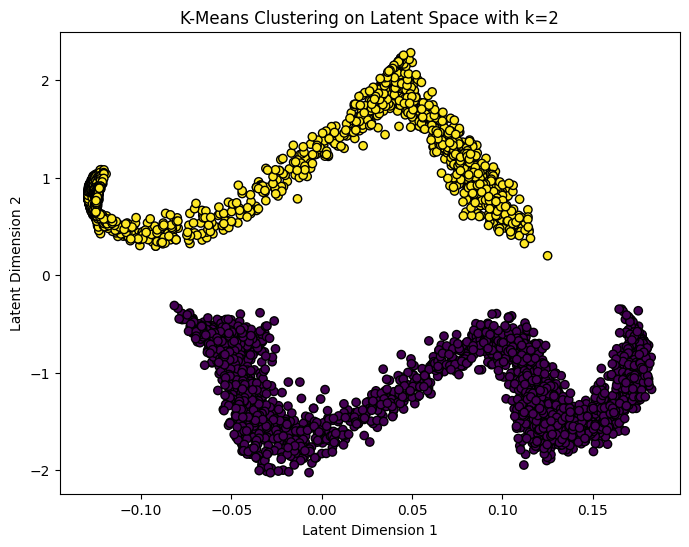

In [19]:
latent_z = np.load('lentent_z.npy')

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(latent_z)  
labels = kmeans.labels_  

plt.figure(figsize=(8, 6))
plt.scatter(latent_z[:, 0], latent_z[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('K-Means Clustering on Latent Space with k=2')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

### g) Can you think of a clustering algorithm that is better suited for this data set? Explain the mechanism behind such an algorithm

DBSCAN (the one we haven't used yet)
    •   Non-linear clusters: DBSCAN can find arbitrarily shaped clusters, unlike K-Means which assumes spherical clusters.
	•	No need to specify the number of clusters: DBSCAN automatically finds the number of clusters based on the density of data points.
	•	Handles noise: DBSCAN can also classify outliers or noise in the data.

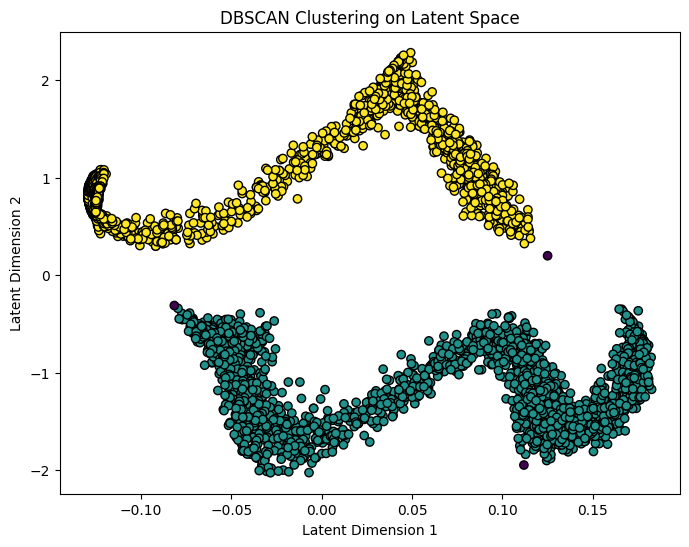

In [20]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering on the latent representation
dbscan = DBSCAN(eps=0.055, min_samples=5)  # some tuning required for eps and min_samples
labels_dbscan = dbscan.fit_predict(latent_z)

# Plot the DBSCAN clustered latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_z[:, 0], latent_z[:, 1], c=labels_dbscan, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clustering on Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

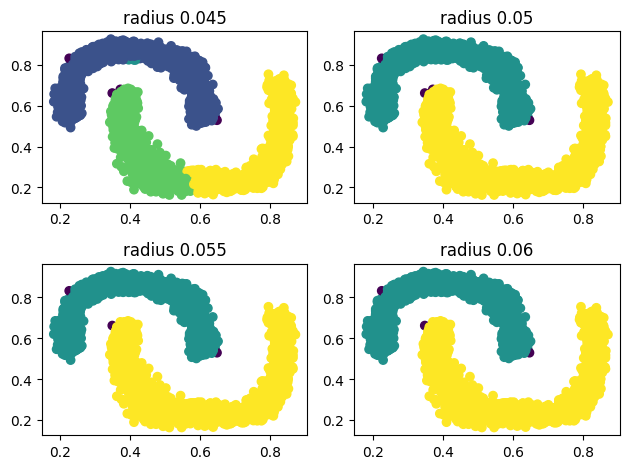

In [22]:
radius = [0.045, 0.05, 0.055, 0.06]
fig, ax = plt.subplots(2,2)
c=0
for i in range(2):
  for j in range(2):
    dbscan = DBSCAN(eps=radius[c], min_samples=5, metric='euclidean')
    labels = dbscan.fit_predict(latent_z)
    ax[i,j].scatter(x[:,0],x[:,1],c=labels)
    ax[i,j].set_title('radius {}'.format(radius[c]))
    c+=1
plt.tight_layout()
plt.show()


## 2) Retail Store Business Case

In [120]:
path = 'retail_store_data.csv'
original_df = pd.read_csv(path)
original_df.head()

,Education,Marital_Status,Income,Kids,Days_is_client,Recency,Expenses,CustomerAge,TotalNumPurchases,TotalAcceptedCmp,Complain,Response
0,Graduate,Single,58138.0,0,663,58,1617,57,25,0,0,1
1,Graduate,Single,46344.0,2,113,38,27,60,6,0,0,0
2,Graduate,Partner,71613.0,0,312,26,776,49,21,0,0,0
3,Graduate,Partner,26646.0,1,139,26,53,30,8,0,0,0
4,Postgraduate,Partner,58293.0,1,161,94,422,33,19,0,0,0


In [121]:
# Checking for missing values in each feature
display(original_df.isnull().any())

Education            False
Marital_Status       False
Income               False
Kids                 False
Days_is_client       False
Recency              False
Expenses             False
CustomerAge          False
TotalNumPurchases    False
TotalAcceptedCmp     False
Complain             False
Response             False
dtype: bool

In [122]:
original_df.shape

(2216, 12)

In [123]:
# Checking for duplicates
print(original_df.duplicated().sum())

# Removing duplicates
df = original_df.drop_duplicates()
print(df.duplicated().sum())

185
0


In [124]:
# Identifying the categorical and numerical variables
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

print("Categorical Variables:")
print(cat_cols)

print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index(['Education', 'Marital_Status'], dtype='object')
Numerical Variables:
['Income', 'Kids', 'Days_is_client', 'Recency', 'Expenses', 'CustomerAge', 'TotalNumPurchases', 'TotalAcceptedCmp', 'Complain', 'Response']


In [125]:
df.describe(include='object').round(2).T
df.describe(include='number').round(2).T

,count,mean,std,min,25%,50%,75%,max
Income,2031.0,52376.80,25539.84,1730.0,35533.5,51563.0,68557.0,666666.0
Kids,2031.0,0.95,0.75,0.0,0.0,1.0,1.0,3.0
Days_is_client,2031.0,352.56,202.34,0.0,178.0,352.0,528.0,699.0
Recency,2031.0,48.89,28.97,0.0,24.0,49.0,74.0,99.0
Expenses,2031.0,608.26,603.75,5.0,69.0,397.0,1048.5,2525.0
CustomerAge,2031.0,45.21,11.98,18.0,37.0,44.0,55.0,121.0
TotalNumPurchases,2031.0,14.89,7.66,0.0,8.0,15.0,21.0,44.0
TotalAcceptedCmp,2031.0,0.30,0.68,0.0,0.0,0.0,0.0,4.0
Complain,2031.0,0.01,0.10,0.0,0.0,0.0,0.0,1.0
Response,2031.0,0.15,0.36,0.0,0.0,0.0,0.0,1.0


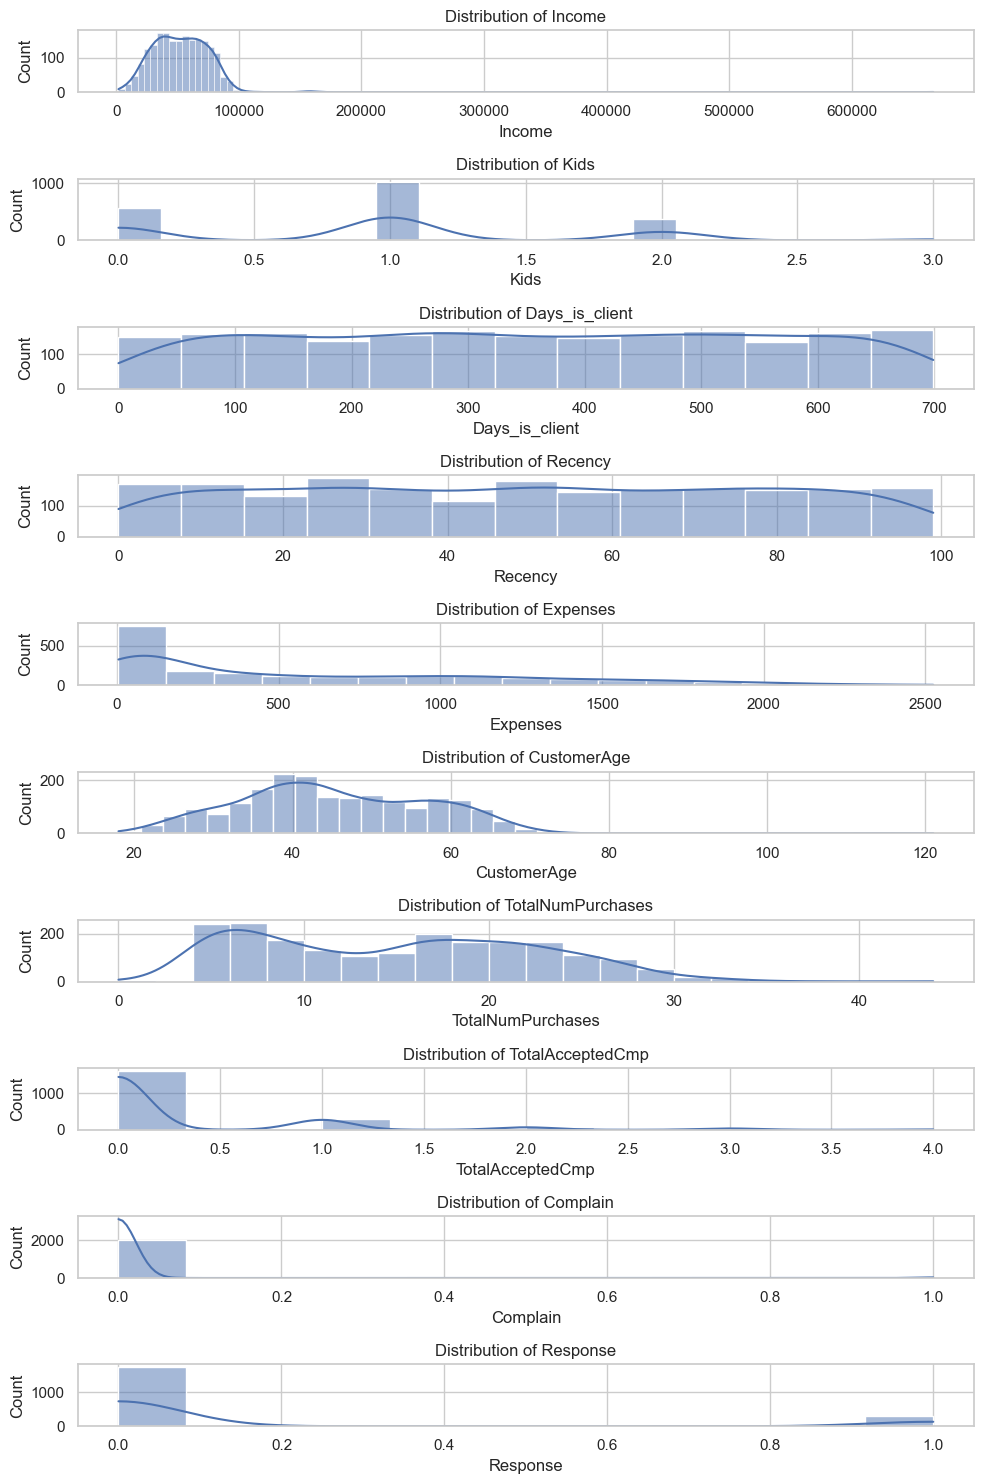

In [126]:
# Plotting the distribution of the numerical variables
fig, axes = plt.subplots(len(num_cols), 1, figsize=(10, 15))

for i, col in enumerate(num_cols):
        sns.histplot(data=df, x=col, ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

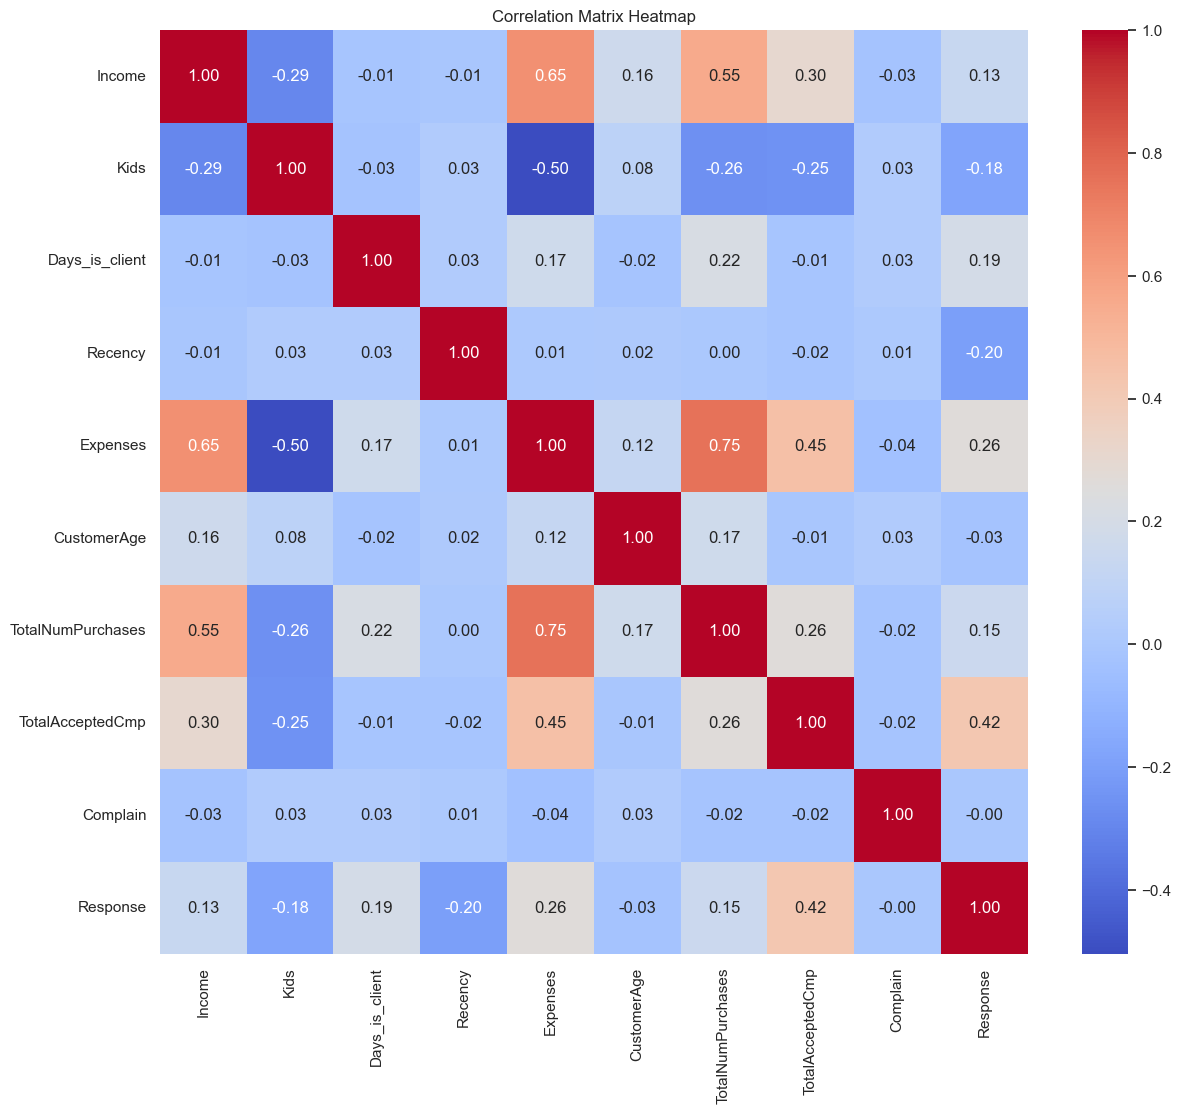

In [127]:
# Plotting the correlation matrix between numerical variables as a heatmap
num_cols = df.select_dtypes(include=np.number).columns.tolist() 
correlation_matrix = df[num_cols].corr() 
plt.figure(figsize=(14, 12)) 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True) 
plt.title("Correlation Matrix Heatmap")

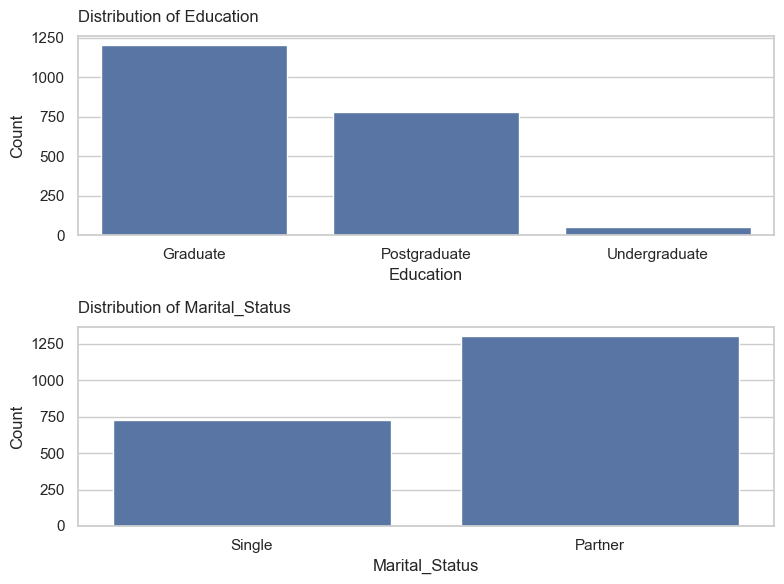

In [128]:
# Plotting the distribution of the categorical variables
fig, axes = plt.subplots(len(cat_cols), 1, figsize=(8, 6))

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=12, loc='left', pad=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### a) What can you say about the data? Recall that it will be used to identify clusters, or groups of customers, in the retail store

In [129]:
df_encoded = pd.get_dummies(df, columns=cat_cols, dtype =int)

In [130]:
df_encoded.head()

,Income,Kids,Days_is_client,Recency,Expenses,CustomerAge,TotalNumPurchases,TotalAcceptedCmp,Complain,Response,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Marital_Status_Partner,Marital_Status_Single
0,58138.0,0,663,58,1617,57,25,0,0,1,1,0,0,0,1
1,46344.0,2,113,38,27,60,6,0,0,0,1,0,0,0,1
2,71613.0,0,312,26,776,49,21,0,0,0,1,0,0,1,0
3,26646.0,1,139,26,53,30,8,0,0,0,1,0,0,1,0
4,58293.0,1,161,94,422,33,19,0,0,0,0,1,0,1,0


In [140]:
# STEP 1
df_mean = df_encoded.mean(axis=0)
df_encoded -= df_mean
# covariance mat
C = np.cov(df_encoded.T)

# STEP 2
# get eigenvectors (v) and eigenvalues (w)
w, v = LA.eig(C)

# STEP 3
# get idx in descending order based on w
inx = w.argsort()[::-1]
# sort eig.vectors and eig.values
w, v = w[inx], v[:, inx]

# STEP 4
# select the number of components
m = 15
# get the first m eig.vectors and eig.values
w = w[:m]
v = v[:, :m]
print('shape eigenvectors',v.shape)

# STEP 5
# project the data
pca = df_encoded.dot(v)

shape eigenvectors (15, 15)
Total Variance: 652690144.4148784
Variance Explained by the top 14 components: 652690144.4148784
Proportion of Variance Explained: 1.0000


### b) What is the reason for using PCA and not reducing the number of dimensions in the input data

The term “rotation” refers to the mathematical transformation in PCA. The data is rotated in such a way that the new axes (principal components) are aligned with the directions of maximum variance in the data.
	•	The principal components are uncorrelated (orthogonal) and are ordered by how much variance they capture from the data.
	•	In simple terms, instead of working with the original 15 variables, you are now working with 15 principal components, which are new axes that better represent the variance in the data but still have the same dimensionality (15).

### c) For K = 1, 2, · · · , 10, plot the Silhouette and Davies-Bouldin scores for both hierarchical clustering and K-means, i.e. you are supposed to show 4 plots

In [154]:
# This parameter tells how many times we repeat the calculations
K = 10

# define dictionaries and lists to save main results
hierarchical_cv = {}
kmeans_cv = {}
hierarchical_silhouette = []
hierarchical_db = []
kmeans_silhouette = []
kmeans_db = []

# we start at 2, since clustering for K=1 doesnt make sense
for k in range(2, K+1):
  # First hierarchical
  P = linkage(pca, method='ward', metric='euclidean')
  cluster_labels = fcluster(P, k, criterion='maxclust')
  # using the cluster_labels we calculate both scores
  silhouette = silhouette_score(pca, cluster_labels)
  db = davies_bouldin_score(pca,cluster_labels)

  # save results
  temp_dict = {'silhouette':silhouette,'db':db}
  hierarchical_cv[k] = temp_dict
  hierarchical_silhouette.append(silhouette)
  hierarchical_db.append(db)

  # Second kmeans
  kmeans = KMeans(n_clusters=k, n_init="auto")
  cluster_labels = kmeans.fit_predict(pca)
  silhouette = silhouette_score(pca, cluster_labels)
  db  = davies_bouldin_score(pca, cluster_labels)

  # save results
  temp_dict = {'silhouette':silhouette,'db':db}
  kmeans_cv[k] = temp_dict
  kmeans_silhouette.append(silhouette)
  kmeans_db.append(db)


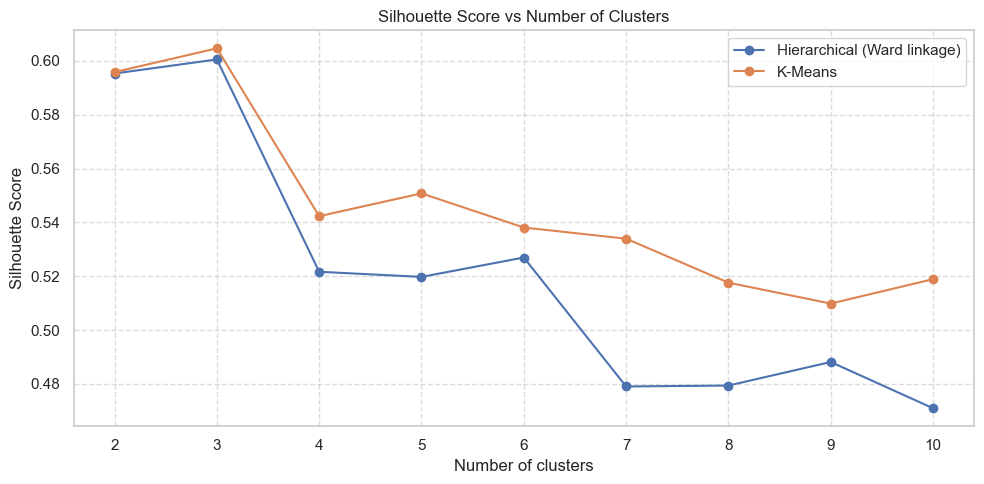

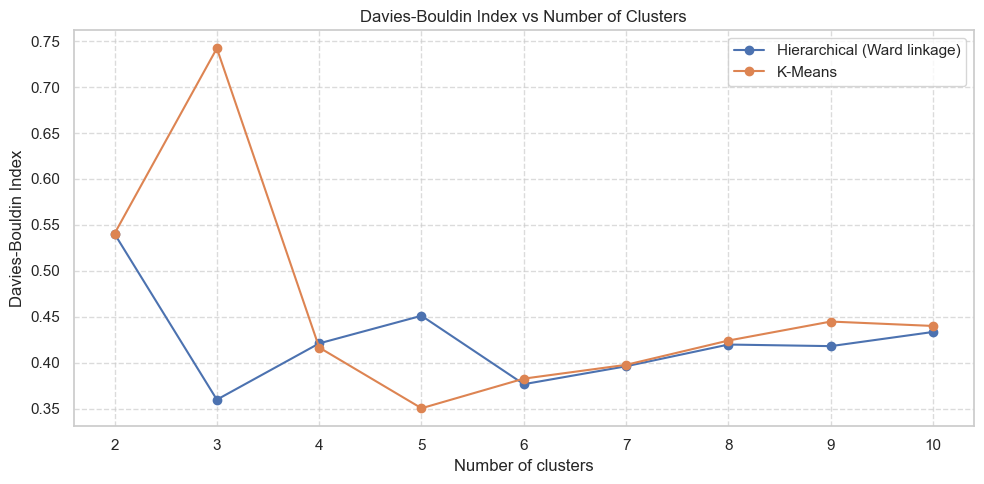

In [153]:
k_range = range(2, K+1)

# Plot the silhouette scores for hierarchical and k-means clustering
plt.figure(figsize=(10, 5))
plt.plot(k_range, hierarchical_silhouette, label='Hierarchical (Ward linkage)', marker='o')
plt.plot(k_range, kmeans_silhouette, label='K-Means', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot the Davies-Bouldin scores for hierarchical and k-means clustering
plt.figure(figsize=(10, 5))
plt.plot(k_range, hierarchical_db, label='Hierarchical (Ward linkage)', marker='o')
plt.plot(k_range, kmeans_db, label='K-Means', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### d) What are the number of clusters suggested by your cross-validation? Does the Silhouette and Davies-Bouldin scores agree with each other?

3

In [170]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, enc, dec, name='autoencoder'):
      super().__init__()
      self.encoder = enc
      self.decoder = dec
      self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

      self.params = encoder.trainable_variables + decoder.trainable_variables

    def call(self, inputs):
      z = self.encoder(inputs)
      x_hat = self.decoder(z)

      self.loss = tf.reduce_mean(tf.keras.losses.MSE(inputs,x_hat))

    @tf.function
    def train(self,x, optimizer):
        with tf.GradientTape() as tape:
            enc_dec = self.call(x)
        gradients = tape.gradient(self.loss, self.params)
        optimizer.apply_gradients(zip(gradients, self.params))

        return self.loss

    def rep_learning(self, x):
      z = self.encoder(x)

      return z

    def reconstruct(self, x):
      z = self.rep_learning(x)
      x_hat = self.decoder(z)

      return x_hat

In [171]:
def plot_digits(x_test,decoded_imgs,n):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # Display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # Display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

def nice_scatter(z_tsne, y_sample, title):
    print('plotting nice scatter...')
    COLORS=[[1.0000, 0,      0     ],
            [0,      1.0000, 0     ],
            [0,      0,      1.0000],
            [1.0000, 0,      1.0000],
            [0.9569, 0.6431, 0.3765],
            [0.4000, 0.8039, 0.6667],
            [0.5529, 0.7137, 0.8039],
            [0.8039, 0.5882, 0.8039],
            [0.7412, 0.7176, 0.4196],
            [0,      0,      0     ]]

    fig, ax = plt.subplots()
    for i, ((x,y),) in enumerate(zip(z_tsne)):
        #rot = random.randint(0,0) # in case you want randomly rotated numbers
        rot = 0
        ax.text(x, y, y_sample[i], color=COLORS[y_sample[i]-1], ha="center", va="center", rotation = rot, fontsize=5)
        ax.plot(x,y, alpha=0.0)
        ax.axis('off')
        plt.title(title)

In [172]:
# hyperparameters
input_shape = (15, )
activation = 'tanh'
units = 35
z_dim = 10

In [173]:
# encoder and decoder architecture
encoder = Sequential([
    layers.InputLayer(input_shape=(input_shape)),
    layers.Dense(units, activation=activation),  # 1st hidden layer
    layers.Dense(units, activation=activation),  # 2nd hidden layer
    layers.Dense(units, activation=activation),  # 3rd hidden layer
    layers.Dense(z_dim, activation='linear'),    # output layer (latent space) with linear activation
])

decoder = Sequential([
    layers.InputLayer(input_shape=(z_dim,)),
    layers.Dense(units, activation=activation),  # 1st hidden layer
    layers.Dense(units, activation=activation),  # 2nd hidden layer
    layers.Dense(units, activation=activation),  # 3rd hidden layer
    layers.Dense(15, activation='linear'),  # output layer with linear activation
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [174]:
seed = 42 # You can choose any number
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

autoencoder = AutoEncoder(encoder, decoder)
batch_size = 256
tr_data  = tf.data.Dataset.from_tensor_slices(pca).shuffle(pca.shape[0]).batch(batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

counter = 0
epochs  = 1000
start = time.time()
losses = []
while counter < epochs:
  for i, x_batch in enumerate(tr_data):
    loss = autoencoder.train(x_batch, optimizer)
    losses.append(loss.numpy())  # storing loss
  counter+=1
  if counter%10==0:
    print('Model has been trained for {} epochs'.format(counter))
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print('Elapsed time: {}m {:.1f}s'.format(int(minutes), seconds))

Model has been trained for 10 epochs
Model has been trained for 20 epochs
Model has been trained for 30 epochs
Model has been trained for 40 epochs
Model has been trained for 50 epochs
Model has been trained for 60 epochs
Model has been trained for 70 epochs
Model has been trained for 80 epochs
Model has been trained for 90 epochs


2024-10-23 19:40:58.818694: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model has been trained for 100 epochs
Model has been trained for 110 epochs
Model has been trained for 120 epochs
Model has been trained for 130 epochs
Model has been trained for 140 epochs
Model has been trained for 150 epochs
Model has been trained for 160 epochs
Model has been trained for 170 epochs
Model has been trained for 180 epochs
Model has been trained for 190 epochs
Model has been trained for 200 epochs
Model has been trained for 210 epochs
Model has been trained for 220 epochs
Model has been trained for 230 epochs
Model has been trained for 240 epochs
Model has been trained for 250 epochs
Model has been trained for 260 epochs
Model has been trained for 270 epochs
Model has been trained for 280 epochs
Model has been trained for 290 epochs
Model has been trained for 300 epochs
Model has been trained for 310 epochs
Model has been trained for 320 epochs
Model has been trained for 330 epochs
Model has been trained for 340 epochs
Model has been trained for 350 epochs
Model has be

### e) Generate the latent representation for all data using the function rep_learning and visualize it in a 2-dimensional scatter plot using the t-SNE dimensionality reduction method

plotting nice scatter...


IndexError: index 3 is out of bounds for axis 0 with size 3

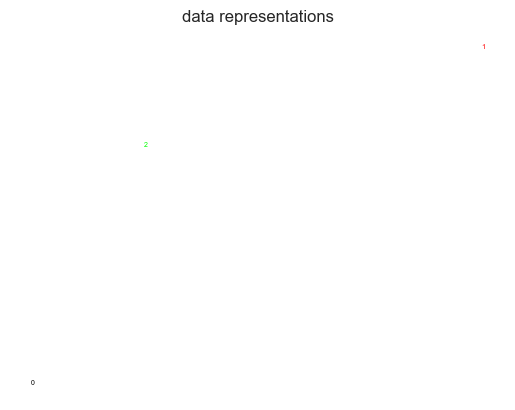

In [178]:
z = autoencoder.rep_learning(pca)
# dimensionality reduction
z_2d = TSNE(n_components=2,n_jobs=-1).fit_transform(z)
# plot a nice scatter
y_sample = np.array([0, 1, 2])
nice_scatter(z_2d, y_sample,'data representations')